
# Convex Optimization Project
## Support Vector Machines solvers

Given $m$ data points $x_i \in \mathbb{R}^n$ with labels $y_i \in \{-1,1\}$, write a function to solve the classification problem

$$ \begin{array}l
\mathrm{minimize} & \frac12 {||w||}_2^2 + C \mathbf{1}^Tz \\
\mathrm{subject\ to} & y_i(w^Tx_i) \geq 1 - z_i, \quad \forall i \in \{1,\ldots,m\} \\
& z \succcurlyeq 0
\end{array} $$

in the variables $w \in \mathbb{R}^n$, $z \in \mathbb{R}^m$, and its dual (warning: this problem is a bit different from the one in exercise 1).

Solving this problem trains a classifier vector $w$ such that, up to some errors

$$ \begin{array}l
w^Tx_i > 0 & \mathrm{when}\ y_i = 1 \\
w^Tx_i < 0 & \mathrm{when}\ y_i = -1.
\end{array} $$

This classifier can then be used to classify new points $x$ as positives or negatives by simply computing the scalar product $w^Tx$.

In [1]:
%pylab inline
from scipy.spatial.distance import cdist
import sklearn.svm
import cvxopt

Populating the interactive namespace from numpy and matplotlib


### General optimization functions
#### Newton

In [2]:
def newton(f, gradient_and_hessian, ɛ, x0, α=0.45, β=0.8):
    """
    Newton descent method.
    @param f is the function to minimize
    @param gradient_and_hessian is a function that returns the gradient and the hessian at x
    @param ɛ is the required absolute precision
    @param x0 is a strictly feasible point, i.e., f(x0) < +inf
    @param α is a parameter for the backtracking line search
    @param β is a parameter for the backtracking line search
    @return a dictionary
    """    
    x = x0
    assert(f(x) < float("inf"))
    central_path = [copy(x)]
    while True:
        # Direction computation.
        gradient, hessian = gradient_and_hessian(x)
        hessian_inv = inv(hessian)
        dx = -hessian_inv.dot(gradient)
        
        # Stopping criterion.
        λsquare = gradient.dot(-dx)
        if λsquare/2 <= ɛ:
            break
        
        # Backtracking line search.
        t = 1.0
        f0 = f(x)
        Δ = -λsquare
        # We stop the search if the function starts to increase, which in theory never happens
        # but might be the consequence of a numerical instability.
        prev_fx = float("inf")
        while f(x + t*dx) > f0 + α*t*Δ and (f(x + t*dx) < prev_fx or prev_fx == float("inf")):
            prev_fx = f(x + t*dx)
            t *= β
        
        # Update.
        x += t*dx
        central_path.append(copy(x))
        
    results = {
        "primal_solution":  copy(x),
        "primal_objective": f(x),
        "central_path":     vstack(central_path),
    }
    return results

#### Barrier

In [3]:
def barrier_method(objective, objective_gh, m, constraints, constraints_gh,
                   ɛ, x0, t0=1.0, μ=10.0, **newton_params):
    """
    Barrier method for inequality-constrained optimization problem.
    @param objective is the function to minimize
    @param objective_gh is a function which returns the gradient and the hessian of the objective
    @param m is the number of (inequality) constraints
    @param constraints is a function which returns the array (of shape m) of the f_i(x) where f_i(x) <= 0
    @param constraints_gh is a function which returns the array of gradients and hessians of sum(-log(-fi(x)))
    @param ɛ is the required absolute precision
    @param x0 is a strictly feasible point, i.e., objective(x0) < +inf and constraints(x0) < 0
    @param t0 is a barrier parameter
    @param μ is a barrier parameter
    @param **newton_params are the additional newton method parameters
    @return a dictionary
    """
    x = x0
    t = t0
    central_path = [copy(x)]
    assert(all(constraints(x) < 0))
    
    # We minimize objective + 1/t sum (-log(-constraints))
    def f(x):
        cons = constraints(x)
        if any(cons >= 0):
            return float("inf")
        return objective(x) - sum(log(-cons))/t
    def gradient_and_hessian(x):
        obj_g, obj_h = objective_gh(x)
        cons_g, cons_h = constraints_gh(x)
        return obj_g + cons_g/t, obj_h + cons_h/t
    
    while True:
        x = newton(f, gradient_and_hessian, ɛ, x, **newton_params)["primal_solution"]
        # Stopping criterion.
        if m/t <= ɛ:
            break
        t *= μ
        central_path.append(copy(x))
    
    cx = constraints(x)
    assert(all(cx < 0))
    results = dict()
    results["primal_solution"] = copy(x)
    results["primal_objective"] = f(x)
    results["dual_solution"] = -1/(t*cx)
    results["dual_objective"] = results["primal_objective"] + results["dual_solution"].dot(cx)
    results["central_path"] = vstack(central_path)
    return results

# Unused version which is more general since it needs the gradients and hessians
# of the f_i instead of the -log(-f_i). This is useful in order to re-use it directly
# for phase one methods. However, it is slower since in the previous settings, we can
# cache some computations and optimize it on a case-by-case basis.
def general_barrier_method(objective, objective_gh, m, constraints, constraints_gh, ɛ, x0, **barrier_params):
    """
    General barrier method for inequality-constrained optimization problem.
    @param objective is the function to minimize
    @param objective_gh is a function which returns the gradient and the hessian of the objective
    @param m is the number of (inequality) constraints
    @param constraints is a function which returns the array (of shape m) of the f_i(x) where f_i(x) <= 0
    @param constraints_gh is a function which returns the array of gradients and hessians of the f_i(x)
    @param ɛ is the required absolute precision
    @param x0 is a strictly feasible point, i.e., objective(x0) < +inf and constraints(x0) < 0
    @param **barrier_params are the additional barrier method parameters
    @return a dictionary
    """
    def cons_gh(x):
        cons = constraints(x)
        cons_g, cons_h = constraints_gh(x) # shape m,n and m,n,n
        
        # Computing the gradient and hessians of the -log(-f_i(x)).
        div = 1 / cons
        log_cons_g = -cons_g * div[:,None]
        log_cons_h = -cons_h * div[:,None,None] - einsum('ij,ik->ijk', log_cons_g, log_cons_g)
        
        return sum(log_cons_g, axis=0), sum(log_cons_h, axis=0)
    
    return barrier_method(objective, objective_gh, m, constraints, cons_gh, ɛ, x0, **barrier_params)

#### Phase one

In [4]:
def phase_one(n, m, constraints, constraints_gh, ɛ, **barrier_params):
    """
    Computes a strictly feasible point by solving the following problem: min s subject to f_i(x) <= s*1_m.
    @param m is the number of (inequality) constraints
    @param constraints is a function which returns the array (of shape m) of the f_i(x) where f_i(x) <= 0
    @param constraints_gh(v) returns the array of gradients and hessians of sum(-log(s-f_i(x))) in v = [s x]
    @param ɛ is the required absolute precision
    @param **barrier_params are the additional barrier method parameters
    @return a strictly feasible point, or None if no such point exists
    """
    # The variable v is the concatenation of s and x.
    x0 = zeros(n)
    v0 = concatenate(((1 + max(constraints(x0))) * ones(1), x0))
    
    def obj(v):
        return v[0]
    def obj_gh(v):
        return concatenate((ones(1), zeros(n))), zeros((n+1, n+1))
    def cons(v):
        return constraints(v[1:]) - v[0]
    
    assert(all(cons(v0) < 0))
        
    # Could be optimized to stop as soon as s < 0.
    results = barrier_method(obj, obj_gh, m, cons, constraints_gh, ɛ, v0, **barrier_params)
    v = results["primal_solution"]
    if v[0] >= 0:
        return None
    return v[1:]

# Unused version which is more general since it requires simpler computations from the user
# (the phase one method is completely transparent and does not require more gradients than
# the simple barrier method). However, it is slower since in the previous settings, we can
# cache some computations and optimize it on a case-by-case basis.
def general_phase_one(n, m, constraints, constraints_gh, ɛ, **barrier_params):
    """
    Computes a strictly feasible point by solving the following problem: min s subject to f_i(x) <= s*1_m.
    @param m is the number of (inequality) constraints
    @param constraints is a function which returns the array (of shape m) of the f_i(x) where f_i(x) <= 0
    @param constraints_gh is a function which returns the array of gradients and hessians of the f_i(x)
    @param ɛ is the required absolute precision
    @param **barrier_params are the additional barrier method parameters
    @return a strictly feasible point, or None if no such point exists
    """
    def cons_gh(v):
        s, x = v[0], v[1:]
        f_i = constraints(x) # shape m
        gradients_f_i, hessians_f_i = constraints_gh(x) # shape m,n and m,n,n
        
        div = 1 / (s - f_i) # shape m
        grad_x = gradients_f_i * (-f_i * div)[:,None] # shape m,n
        gradients = concatenate((-div.reshape(m,1), grad_x), axis=1) # shape m,n+1
        hess_xs = -grad_x * div[:,None] # shape m,n
        hessians = concatenate((concatenate(((div**2).reshape(m,1,1), 
                                             hess_xs.reshape(m,n,1)),
                                            axis=1), # shape m,n+1,1
                                concatenate((hess_xs.reshape(m,1,n), 
                                             hessians_f_i),
                                            axis=1)), # shape m,n+1,n
                               axis=2) # shape m,n+1,n+1
        return gradients, hessians
        
    # Could be optimized to stop as soon as s < 0.
    results = general_barrier_method(obj, obj_gh, m, cons, cons_gh, ɛ, v0, **barrier_params)
    v = results["primal_solution"]
    if v[0] >= 0:
        return None
    return v[1:]
    
# Unused.
def barrier_phase_one(n, objective, objective_gh, m, constraints, constraints_gh, ɛ, **barrier_params):
    """
    Barrier method for inequality-constrained optimization problem, without a known starting point.
    @param n is the dimension of the input space
    @param objective is the function to minimize
    @param objective_gh is a function which returns the gradient and the hessian of the objective
    @param m is the number of (inequality) constraints
    @param constraints is a function which returns the array (of shape m) of the f_i(x) where f_i(x) <= 0
    @param constraints_gh(v) returns the array of gradients and hessians of sum(-log(s-f_i(x))) in v = [s x]
    @param **barrier_params are the additional barrier method parameters
    @return a dictionary, or None if the domain is empty.
    """
    x0 = phase_one(n, m, constraints, constraints_gh, ɛ, **barrier_params)
    if x0 is None:
        return None
    
    def cons_gh(x):
        v = concatenate(x, zeros(1))
        gradient_v, hessian_v = constraints_gh(v)
        return gradient_v[1:], hessian_v[1:,1:]
    return barrier_method(objective, objective_gh, m, constraints, cons_gh, ɛ, x0, **barrier_params)

#### Coordinate descent

In [5]:
def coordinate_descent(f, step, ɛ, x0):
    """
    Coordinate descent method.
    @param f is the function to minimize
    @param step takes x and i as an input and returns the new xi (performs a coordinate descent step)
    @param ɛ is the required absolute precision
    @param x0 is the starting point
    @return a dictionary
    """
    n = len(x0)
    x = x0
    f_x = f(x)
    central_path = [copy(x)]
    
    while True:
        old_f_x = f_x
        for i in range(n):
            x[i] = step(x, i)
        
        f_x = f(x)
        if abs(f_x - old_f_x) < ɛ:
            break
        central_path.append(copy(x))
    
    results = {
        "primal_solution": x,
        "primal_objective": f_x,
        "central_path": vstack(central_path),
    }
    return results

#### Analytic Center Cutting Plane

We need to compute the gradient and the hessian of $$g_i(x, s) = -\log(s + b_i - a_i^T x)$$

With $d_i(x,s) = b_i + s - a_i^Tx$, in terms of the variable $v = \left[ \begin{array}c s & x \end{array} \right]$,
$$ \nabla_v g_i(x, s) = \frac1{d_i(x,s)} \left[ \begin{array}c -1 & a_i \end{array} \right] \\
H_vg_i(x, s) = \frac1{d_i(x,s)^2} \left[ \begin{array}c 1 & -a_i^T \\ -a_i & a_ia_i^T \end{array} \right]
$$

In [7]:
def accpm(f, gradient, a, b, ɛ, drop_constraints=False, max_constraints=float("inf"), **barrier_params):
    """
    Analytic Center Cutting Plane Method for solving min f(x) subject to ax <= b.
    @param f is the function to minimize
    @param gradient is a function that returns the gradient at x
    @param a defines the initial linear constraints
    @param b defines the initial linear constraints
    @param ɛ is the required absolute precision
    @param drop_constraints whether to drop constraints
    @param max_constraints maximum number of constraints to keep
    @param **barrier_params are the additional barrier method parameters
    @return a dictionary, or None if the domain is empty.
    """
    m, n = a.shape
    # Build the extended matrix and the tensor of the ax_i ax_i^T.
    ax = concatenate((-ones((m, 1)), a), axis=1)
    scalarsx = einsum('ij,ik->ijk', ax, ax)
    bx = copy(b)
    
    def objective(x):
        c = bx - ax[:,1:].dot(x)
        if any(c <= 0):
            return float("inf")
        return -sum(log(c))
    def objective_gh(x):
        assert(all(bx - ax[:,1:].dot(x) > 0))
        d = 1 / (bx - ax[:,1:].dot(x))
        gradient = sum(ax[:,1:] * d[:,None], axis=0)
        hessian = sum(scalarsx[:,1:,1:] * (d**2)[:,None,None], axis=0)
        return gradient, hessian
    def constraints(x):
        return ax[:,1:].dot(x) - bx
    def constraints_gh(v):
        assert(all(bx - ax.dot(v) > 0))
        d = 1 / (bx - ax.dot(v))
        gradient = sum(ax * d[:,None], axis=0)
        hessian = sum(scalarsx * (d**2)[:,None,None], axis=0)
        return gradient, hessian
    
    central_path = []
    x_star = None
    u = float("inf")
    l = float("-inf")
    while True:
        # A phase one could be avoided since we added at most one constraint...
        x0 = phase_one(n, m, constraints, constraints_gh, ɛ, **barrier_params)
        print("Phase one finished")
        results = newton(objective, objective_gh, ɛ, x0, **barrier_params)
        print("Newton finished")
        x = results["primal_solution"]
        central_path.append(copy(x))
            
        # Stopping criterion.
        f_x = f(x)
        if f_x < u:
            x_star = x
            u = f_x
        grad = gradient(x)
        _, h_star = objective_gh(x)
        inv_h_star = inv(h_star)
        m, _ = ax.shape
        l = max(l, f_x - m*sqrt(inv_h_star.dot(grad).dot(grad)))
        if u - l < ɛ:
            break            
        
        # Add a new constraint.
        gradx = concatenate((-ones(1), grad), axis=0)
        bx = concatenate((bx, grad.dot(x)*ones(1)))
        ax = concatenate((ax, gradx.reshape(1, n+1)), axis=0)
        scalarsx = concatenate((scalarsx, gradx[None,:,None] * gradx[None,None,:]), axis=0)
        
        # Constraints dropping.
        # Could be done less often than at every step (such as when it has doubled).
        if drop_constraints:
            η = constraints(x) / sqrt(einsum('ij,ik->i', ax[:,1:], ax[:,1:].dot(h)))
            idx = η < m
            new_m = sum(idx)  
            if new_m > max_constraints:
                idx = argpartition(η, max_constraints) < max_constraints
            ax = ax[idx]
            bx = bx[idx]
        
    results = {
        "primal_solution": x_star,
        "central_path": vstack(central_path),
    }
    return results

### Kernels

In [8]:
def linear_kernel(X1, X2):
    return X1.dot(X2.T)

def affine_kernel(X1, X2):
    return linear_kernel(X1, X2) + 1

def exponential_kernel(σ):
    def exponential_kernel_σ(X1, X2):
        return np.exp(-cdist(X1, X2) / (2*σ))
    return exponential_kernel_σ

def polynomial_kernel(d):
    def polynomial_kernel_d(X1, X2):
        return (affine_kernel(X1, X2)) ** d
    return polynomial_kernel_d

kernels = {
    "linear": linear_kernel,
    "affine": affine_kernel,
    "exponential": exponential_kernel(1),
    "polynomial": polynomial_kernel(4),
}
n_kernels = len(kernels)

### Classifiers
#### Barrier method

If we compute the dual, we get the following minimization problem:
\begin{equation*}
\begin{aligned}
& \underset{\alpha}{\text{minimize}}
& & \frac12 \alpha^T \mathbf{diag}(y)XX^T\textbf{diag}(y)\alpha - \mathbf{1}^T\alpha \\
& \text{subject to}
& & 0 \le \alpha \le C
\end{aligned}
\end{equation*}

where we can recover the primal solution: $w= \sum_{i=1}^m \alpha_i y_i x_i$

Thus, we use the barrier method to solve both primal and duals:
\begin{equation*}
\begin{aligned}
& \underset{\alpha}{\text{minimize}}
& & \frac12 \alpha^T \mathbf{diag}(y)XX^T\textbf{diag}(y)\alpha - \mathbf{1}^T\alpha - \frac1t \sum_{i=1}^m (\log(\alpha_i) + \log(C - \alpha_i))
\end{aligned}
\end{equation*}

We first compute the formula for the gradient and the hessian matrix.
We first set $H = \mathbf{diag}(y)XX^T\textbf{diag}(y)$.
Then, we get:
$$\nabla f = H \alpha - \mathbf{1} + \frac1t \sum_{i=1}^m (-\frac1{\alpha_i} + \frac1{C-\alpha_i})e_i\\
\nabla^2 f = H + \frac1t \textbf{diag}(\frac1{\alpha_i^2} + \frac1{(C-\alpha_i)^2})
$$

In [9]:
def svm_barrier(x, y, c, kernel, ɛ, **barrier_params):
    """
    Solve the SVM classifier problem.
    @param x is an array of shape (m,n): the m points in dimension n
    @param y is an array of shape m and of values in {-1,1}: the labels
    @param c is the margin parameter
    @param kernel is the kernel function, which takes 2D arrays as inputs
    @param ɛ is the required absolute precision
    @param barrier_params are the additional barrier method parameters
    @return a dictionnary, with at least the α field
    """
    m, n = x.shape
    # α = c/2 is a stricly feasible point.
    α0 = c/2 * ones(m)
    h = kernel(x, x) * y[:, None] * y[None, :]
    
    def objective(α):
        return h.dot(α).dot(α)/2 - sum(α)
    def objective_gh(α):
        return h.dot(α) - 1, h
    def constraints(α):
        return concatenate((-α, α-c))
    def constraints_gh(α):
        gradient = -1/α + 1/(c-α)
        hessian = diag(1/α**2 + 1/(c-α)**2)
        return gradient, hessian
    
    results = barrier_method(objective, objective_gh, 2*m, constraints, constraints_gh, ɛ, α0, **barrier_params)
    results["α"] = results["primal_solution"]   
    return results

#### Coordinate descent

We want to solve for each $1 \le i \le n$ the following optimization problem:
\begin{equation*}
\begin{aligned}
& \underset{\alpha_i}{\text{minimize}}
& & \frac12 \alpha^T H\alpha - \mathbf{1}^T\alpha \\
& \text{subject to}
& & 0 \le \alpha_i \le C
\end{aligned}
\end{equation*}
where $H = \mathbf{diag}(y)XX^T\textbf{diag}(y)$.

We compute the derivative:
$$\frac{\partial f}{\partial \alpha_i}(\alpha_i) = H_i^T\alpha-1$$
so the minimum is obtained with $$\alpha_i = \frac{1 - \alpha^TH'_i}{H_{i, i}} \quad \text{(clamped to } [0,C] \text{)}$$
where $H'_{i}$ is $H_i$ with a null $i^ {th}$ coordinate.

In [10]:
def svm_cd(x, y, c, kernel, ɛ, **cd_params):
    """
    Solve the SVM classifier problem, using coordinate descent to solve the dual.
    @param x is an array of shape (m,n): the m points in dimension n
    @param y is an array of shape m and of values in {-1,1}: the labels
    @param c is the margin parameter
    @param kernel is the kernel function, which takes 2D arrays as inputs
    @param ɛ is the required absolute precision (which should be not too small, as this is a first order method)
    @param **cd_params are the additional coordinate descent parameters
    @return a dictionnary, with at least the α field
    """
    m, n = x.shape
    # α = c/2 is a stricly feasible point.
    α0 = c/2 * ones(m)
    
    h = kernel(x, x) * y[:, None] * y[None, :]
    non_null_indices = np.nonzero(np.diag(h))[0]
    diagonal = np.zeros(m)
    diagonal[non_null_indices] = 1 / h[non_null_indices, non_null_indices]
    h_null = np.copy(h)
    h_null[non_null_indices, non_null_indices] = 0
    
    def f(α):
        return 0.5 * α.dot(np.dot(h, α)) - np.sum(α)
    def step(α, i):
        if h[i,i] == 0:
            return α[i]
        return clip(diagonal[i] * (1 - α.dot(h_null[i])), 0, c)
    
    results = coordinate_descent(f, step, ɛ, α0, **cd_params)
    results["α"] = results["primal_solution"]
    return results

#### ACCPM

In [11]:
def svm_accpm(x, y, c, kernel, ɛ, **accpm_parameters):
    """
    Solve the SVM classifier problem, by solving the primal with ACCPM.
    @param x is an array of shape (m,n): the m points in dimension n
    @param y is an array of shape m and of values in {-1,1}: the labels
    @param c is the margin parameter
    @param kernel is the kernel function, which takes 2D arrays as inputs - unused as we solve the primal
    @param ɛ is the required absolute precision (which should be not too small, as this is a first order method)
    @param **accpm_params are the additional accpm parameters
    @return a dictionnary, without the α field
    """
    # We use the variable t = [w z].
    m, n = x.shape
    a = concatenate((concatenate((-x*y[:,None], -eye(m)), axis=1),
                     concatenate((zeros((m, n)), -eye(m)), axis=1),
                    ), axis=0)
    b = concatenate((-ones(m), zeros(m)))
    
    def f(t):
        w, z = t[:n], t[n:]
        return sum(w**2)/2 + c*sum(z)
    def gradient(t):
        return concatenate((t[:n], c*ones(m)))
    
    results = accpm(f, gradient, a, b, ɛ, **accpm_parameters)
    t = results["primal_solution"]
    results["w"] = t[:n]
    results["z"] = t[n:]
    return results

#### Third-party classifiers

In [12]:
def svm_sklearn(x, y, c, kernel, ɛ, **svc_params):
    m, n = x.shape
    classifier = sklearn.svm.SVC(C=c, kernel=kernel, tol=ɛ, **svc_params)
    classifier.fit(x, y)
    
    α = zeros(m)
    n_support = len(classifier.support_)
    for i in range(n_support):
        α[classifier.support_[i]] = abs(classifier.dual_coef_[0][i])
    results = {
        "α": α
    }
    return results    

def svm_cvxopt(x, y, c, kernel, ɛ, **cvxopt_params):
    cvxopt.solvers.options["show_progress"] = False
    cvxopt.solvers.options["abstol"] = ɛ
    
    # Minimize 1/2 x^T P x + q^T x subject to Gx <= h.
    m, n = x.shape
    P = cvxopt.matrix(kernel(x, x) * y[:, None] * y[None, :])
    q = cvxopt.matrix(-ones(m))
    G = cvxopt.matrix(concatenate((-eye(m), eye(m)), axis=0))
    h = cvxopt.matrix(concatenate((zeros(m), c*ones(m))))
    
    results = cvxopt.solvers.qp(P, q, G, h)
    results["α"] = array(results["x"]).flatten()
    return results

In [13]:
classifiers = {
#     "barrier": svm_barrier,
    "sklearn": svm_sklearn,
#     "cvxopt":  svm_cvxopt,
    "cd":      svm_cd,
    "accpm":   svm_accpm,
}
n_classifiers = len(classifiers)

def train(classifier_name, x, y, c, kernel, ɛ, **classifier_params):
    """
    Trains a classifier, and adds the support vectors and the predict functions to the result dictionnary.
    """
    results = classifiers[classifier_name](x, y, c, kernel, ɛ, **classifier_params)
    
    if "α" in results:
        α = results["α"]
        support_vectors_indices = where(α > 1e-6)[0]
        support_vectors = x[support_vectors_indices]
        support_vectors_weights = α[support_vectors_indices] * y[support_vectors_indices]

        def predict(x):
            return kernel(x, support_vectors).dot(support_vectors_weights)
        def predict_labels(x):
            return (predict(x) > 0.) * 2 - 1

        results["support_vectors_indices"] = support_vectors_indices
        results["support_vectors_weights"] = support_vectors_weights
        results["support_vectors"] = support_vectors
        results["predict"] = predict
        results["predict_labels"] = predict_labels

        # Note: these only make sense with the linear kernel.
        if "central_path" in results:
            αs = results["central_path"]
            ws = sum((αs * y[None,:])[:,:,None] * x[None,:,:], axis=1)
            zs = clip(1 - y[None,:] * ws.dot(x.T), 0, None)

            primal_objectives = sum(ws**2, axis=1)/2 + c*sum(zs, axis=1)
            h = kernel(x, x) * y[:,None] * y[None,:]
            dual_objectives = einsum('ij,ij->i', αs.dot(h), αs)/2 - sum(αs, axis=1)
            results["duality_gaps"] = primal_objectives - dual_objectives
    else:
        w = results["w"]
        
        def predict(x):
            return x.dot(w)
        def predict_labels(x):
            return (predict(x) > 0.) * 2 - 1

        results["predict"] = predict
        results["predict_labels"] = predict_labels
        
    return results

### Data generation

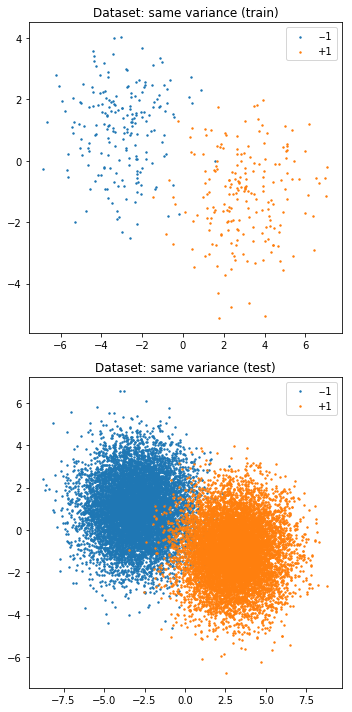

In [14]:
def data_points(μ1, Σ1, μ2, Σ2, n_train, n_test, μ3=None, Σ3=None):
    """
    Generates a dataset composed of two bivariate gaussian samples with different means.
    @param μ1 is the mean of the first sample (+1)
    @param Σ1 is the covariance matrix of the first sample (+1)
    @param μ2 is the mean of the second sample (-1)
    @param Σ2 is the covariance matrix of the second sample
    @param n_train is the number of points of each sample in the training set
    @param n_train is the number of points of each sample in the training set
    @param μ3 is the mean of the first sample (+1) (if provided, will make a mixture of gaussians)
    @param Σ3 is the covariance matrix of the first sample (+1) (if provided, will make a mixture of gaussians)
    @return ((x_train, y_train), (x_test, y_test))
    """
    def pos_examples(n):
        pos_examples = random.multivariate_normal(μ1, Σ1, n)
        if μ3 is not None:
            pos_examples[:n//2] = random.multivariate_normal(μ3, Σ3, n//2)
        return pos_examples
    def neg_examples(n):
        return random.multivariate_normal(μ2, Σ2, n)
    def generate(n):
        x = concatenate((pos_examples(n), neg_examples(n)), axis=0)
        y = concatenate((ones(n),         -ones(n)),        axis=0)
        return x,y
    return generate(n_train), generate(n_test)

def plot_dataset(dataset, test=False):
    """
    Plots training or testing points in the dataset.
    """
    x, y = dataset[int(test)]
    scatter(x[y ==  1][:, 0], x[y ==  1][:, 1], s=2, label="--1")
    scatter(x[y == -1][:, 0], x[y == -1][:, 1], s=2, label="+1")
    title("Dataset: {}".format(name))
    legend()

μ1 = array([-3, 1])
Σ1 = array([[2.5,0],[0,2]])
μ2 = array([3, -1])
Σ2 = array([[3, 1],[1, 3]])
μ3 = array([-3,-4])
Σ3 = array([[4,-1.25],[-1.25,0.5]])
n_train = 200
n_test = 10000
datasets = {
    "same variance":            data_points(μ1, Σ1, μ2, Σ1, n_train, n_test),
#     "different variance":       data_points(μ1, Σ1, μ2, Σ2, n_train, n_test),
#     "mixture of two gaussians": data_points(μ1, Σ1, μ2, Σ2, n_train, n_test, μ3, Σ3),
}
n_datasets = len(datasets)

figure(figsize=(5*n_datasets,10))
i = 0
for name in datasets:
    i += 1
    subplot(2, n_datasets, i)
    plot_dataset(datasets[name], test=False)
    title("Dataset: {} ({})".format(name, "train"))
    subplot(2, n_datasets, i+n_datasets)
    plot_dataset(datasets[name], test=True)
    title("Dataset: {} ({})".format(name, "test"))
tight_layout()

### Test functions

In [15]:
def plot_contours(results, xx, yy, **contourf_params):
    """
    Plot the decision boundaries of a classifier.
    @param results is the result dictionnary of a classifier
    @param xx is the meshgrid array
    @param yy is the meshgrid array
    @param contourf_params are the additional contourf parameters
    """
    z = results["predict"](c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    contourf(xx, yy, z, [-1, 0, 1], **contourf_params)
    contour( xx, yy, z, [-1, 0, 1], colors=["C1", "C7", "C0"])

def plot_results(axes, dataset_name, classifier_name, kernel_name, c=1, ɛ=1e-10):
    dataset = datasets[dataset_name]
    (x_train, y_train), (x_test, y_test) = dataset
    results = train(classifier_name, x_train, y_train, c, kernels[kernel_name], ɛ)
    
    plot_dataset(dataset)
    
    n_grid = 100
    x_min, x_max = axes.get_xlim()
    y_min, y_max = axes.get_ylim()
    xx, yy = meshgrid(linspace(x_min, x_max, n_grid), linspace(y_min, y_max, n_grid))
    plot_contours(results, xx, yy, cmap=plt.cm.coolwarm_r)
    
    if "α" in results:
        scatter(results["support_vectors"][:, 0], results["support_vectors"][:, 1], s=10, linewidth=1, c='gray')
    title("Dataset: {}, classifier: {}\n{} kernel, C={:.0e}".format(
        dataset_name, classifier_name, kernel_name, c), fontsize="x-large")
    
    def accuracy(x, y):
        labels = results["predict_labels"](x)
        return mean(labels != y) * 100
    xlabel("Train Error: {:.2f}%      Test Error: {:.2f}%".format(
        accuracy(x_train, y_train), accuracy(x_test, y_test)), fontsize="large")
    
def plot_duality_gap(axes, dataset_name, classifier_name, kernel_name, c=1, ɛ=1e-10):
    dataset = datasets[dataset_name]
    (x_train, y_train), (x_test, y_test) = dataset
    results = train(classifier_name, x_train, y_train, c, kernels[kernel_name], ɛ)
    
    duality_gaps = results["duality_gaps"]
    plot(arange(len(duality_gaps)), duality_gaps)
    title("Dataset: {}, classifier: {}\n{} kernel, C={:.0e}".format(
        dataset_name, classifier_name, kernel_name, c), fontsize="x-large")
    xlabel("Number of steps", fontsize="x-large")
    ylabel("Duality gap", fontsize="x-large")

### Comparison with other solvers

Dataset: same variance, sklearn classifier
CPU times: user 61.4 ms, sys: 105 ms, total: 167 ms
Wall time: 65.4 ms
Dataset: same variance, cd classifier
CPU times: user 106 ms, sys: 304 ms, total: 409 ms
Wall time: 164 ms
Dataset: same variance, accpm classifier
Phase one finished


KeyboardInterrupt: 

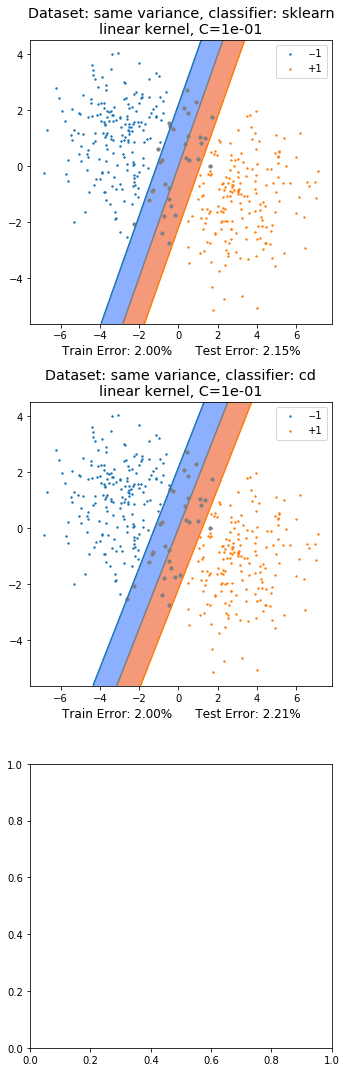

In [16]:
figure(figsize=(5*n_datasets,5*n_classifiers))
i = 0
for classifier in classifiers:
    for dataset in datasets:
        i += 1
        axes = subplot(n_classifiers, n_datasets, i)
        print("Dataset: {}, {} classifier".format(dataset, classifier))
        %time plot_results(axes, dataset, classifier, "linear", c=1e-1, ɛ=1e-6)
tight_layout()

# TODO Commentary

### Convergence plots
Include here duality gap for barrier and coordinate descent (+newton phases), convergence of accpm

### Choice of kernel

Dataset: same variance, linear kernel


KeyError: 'barrier'

Dataset: same variance, affine kernel


KeyError: 'barrier'

Dataset: same variance, exponential kernel


KeyError: 'barrier'

Dataset: same variance, polynomial kernel


KeyError: 'barrier'

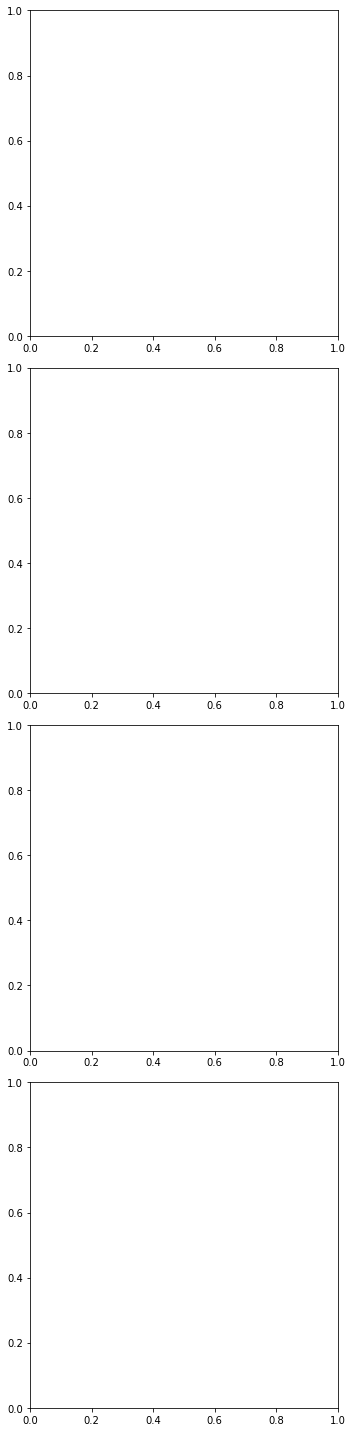

In [17]:
figure(figsize=(5*n_datasets,5*n_kernels))
i = 0
for kernel in kernels:
    for dataset in datasets:
        i += 1
        axes = subplot(n_kernels, n_datasets, i)
        print("Dataset: {}, {} kernel".format(dataset, kernel))
        %time plot_results(axes, dataset, "barrier", kernel, c=1e-1)
tight_layout()

# TODO commentary

### Influence of $C$

Dataset: same variance, C=0.001


KeyError: 'barrier'

Dataset: same variance, C=0.01


KeyError: 'barrier'

Dataset: same variance, C=0.1


KeyError: 'barrier'

Dataset: same variance, C=1.0


KeyError: 'barrier'

Dataset: same variance, C=10.0


KeyError: 'barrier'

Dataset: same variance, C=100.0


KeyError: 'barrier'

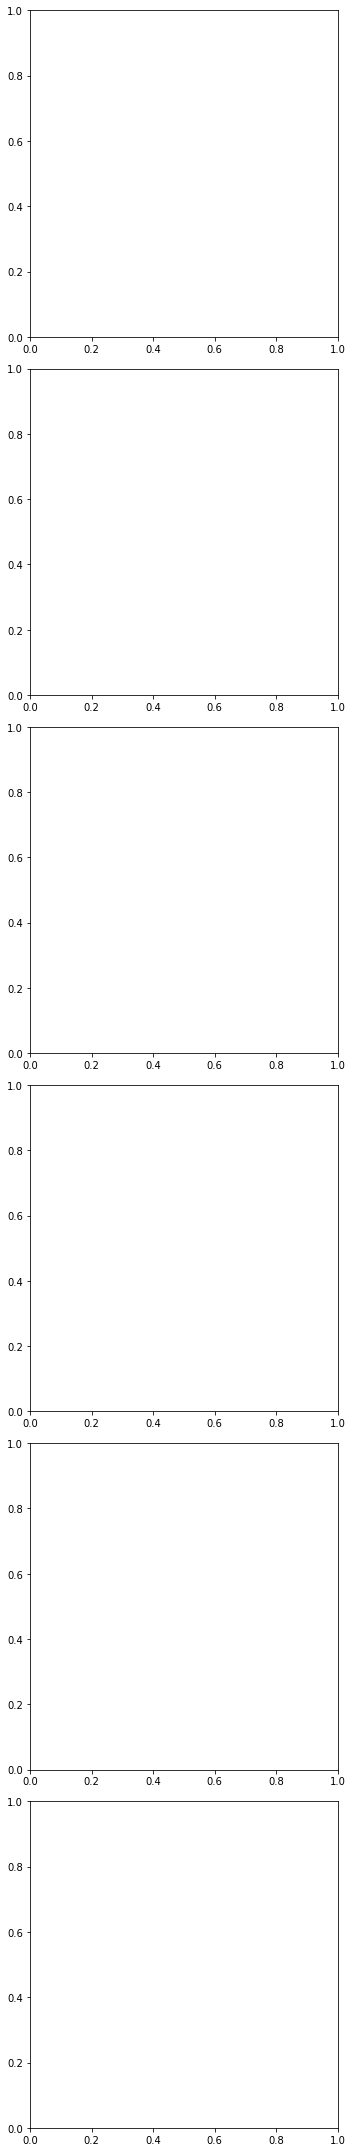

In [18]:
cs = 10.0**arange(-3,3)
n_cs = len(cs)

figure(figsize=(5*n_datasets,5*n_cs))
i = 0
for c in cs:
    for dataset in datasets:
        i += 1
        axes = subplot(n_cs, n_datasets, i)
        print("Dataset: {}, C={}".format(dataset, c))
        %time plot_results(axes, dataset, "barrier", "polynomial", c, c*1e-10)
tight_layout()

# TODO Commentary

### Duality Gap

Dataset: same variance, barrier classifier


KeyError: 'barrier'

Dataset: same variance, coordinate classifier


KeyError: 'coordinate'

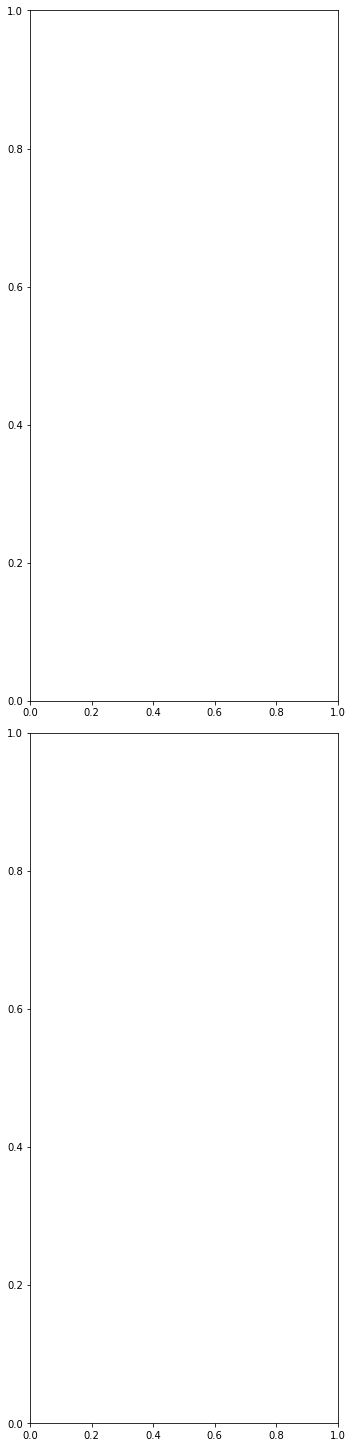

In [19]:
figure(figsize=(5*n_datasets,2*15))
i = 0
for classifier in ["barrier", "coordinate"]:
    for dataset in datasets:
        i += 1
        axes = subplot(n_classifiers, n_datasets, i)
        print("Dataset: {}, {} classifier".format(dataset, classifier))
        %time plot_duality_gap(axes, dataset, classifier, "linear", c=1e-1, ɛ=1e-6)
tight_layout()

# TODO commentary, why doesn't it decreases to 0?
And compare with coordinate descent:
Use the coordinate descent method to solve the dual. Plot duality gap versus iteration number and compare performance with the barrier method for various problem sizes (vary the number of samples and record to total CPU time required by each code to reduce the gap by a factor ${10}^{-3}$).

In [20]:
%time plot_results(axes, dataset, "coordinate", "exponential", c=1e-1)
plt.show()
%time plot_results(axes, dataset, "barrier", "exponential", c=1e-1)

KeyError: 'coordinate'

KeyError: 'barrier'

# TODO
Use the logarithmic barrier code you wrote in HW1 to solve a small random instance of the primal problem using the ACCPM algorithm. Plot an upper bound on the distance to optimality in semilog scale and try various constraint dropping strategies. Compare convergence with the two other methods.